# ResNet on CIFAR10 using Julia

## Configuration

Imports

In [1]:
using Flux

In [2]:
using CUDA

In [3]:
using ParameterSchedulers

In [4]:
using MLDatasets

In [5]:
using Images

In [6]:
using Augmentor

In [7]:
using IterTools

In [8]:
using OnlineStats

In [9]:
using Printf

Configuration

In [10]:
Base.@kwdef struct Config
    batchsize = 32
    throttle = 40
    lr = 1e-3
    wd = 1f-2
    epochs = 100
end

config = Config();

In [11]:
if CUDA.has_cuda()
    @info "CUDA is on"
    CUDA.allowscalar(false)
end

┌ Info: CUDA is on
└ @ Main In[11]:2


## Data

One needs to download data only once:

In [12]:
# CIFAR10.download(i_accept_the_terms_of_use=true)

In [13]:
train_data = CIFAR10.traindata(Float32)
test_data = CIFAR10.testdata(Float32);

In [14]:
train_aug = FlipX(0.5) |> ShearX(-5:5) * ShearY(-5:5) |> Rotate(-15:15) |> CropSize(32,32) |>
            Zoom(0.9:0.1:1.2) |> SplitChannels() |> PermuteDims(3, 2, 1) |> ConvertEltype(Float32)

8-step Augmentor.ImmutablePipeline:
 1.) Either: (50%) Flip the X axis. (50%) No operation.
 2.) Either: (50%) ShearX by ϕ ∈ -5:5 degree. (50%) ShearY by ψ ∈ -5:5 degree.
 3.) Rotate by θ ∈ -15:15 degree
 4.) Crop a 32×32 window around the center
 5.) Zoom by I ∈ {0.9×0.9, 1.0×1.0, 1.1×1.1, 1.2×1.2}
 6.) Split colorant into its color channels
 7.) Permute dimension order to (3, 2, 1)
 8.) Convert eltype to Float32

In [15]:
function collate((imgs, labels))
    imgs = imgs |> gpu
    labels = Flux.onehotbatch(labels .+ 1, 1:10) |> gpu
    imgs, labels
end

collate (generic function with 1 method)

In [16]:
function collate((imgs, labels), aug)
    imgs_aug = Array{Float32}(undef, size(imgs))
    augmentbatch!(imgs_aug, CIFAR10.convert2image(imgs), aug)
    collate((imgs_aug, labels))
end

collate (generic function with 2 methods)

In [17]:
train_loader = imap(d -> collate(d, train_aug),
    Flux.Data.DataLoader(train_data, batchsize=config.batchsize, shuffle=true))

test_loader = imap(collate,
    Flux.Data.DataLoader(test_data, batchsize=config.batchsize, shuffle=false));

truck


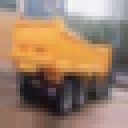

In [18]:
batch = iterate(train_loader)[1]
println(CIFAR10.classnames()[Flux.onecold(cpu(batch[2])[:, 1], 1:10)])
CIFAR10.convert2image(cpu(batch[1])[:,:,:, 1])

## Model

In [19]:
function conv_block(ch::Pair; kernel_size=3, stride=1, activation=relu)
    Chain(Conv((kernel_size, kernel_size), ch, pad=SamePad(), stride=stride, bias=false, init=Flux.kaiming_normal),
          BatchNorm(ch.second, activation))
end

conv_block (generic function with 1 method)

In [20]:
function basic_residual(ch::Pair)
    Chain(conv_block(ch),
          conv_block(ch.second => ch.second, activation=identity))
end

basic_residual (generic function with 1 method)

In [21]:
struct AddMerge
    gamma
    expand
end

Flux.@functor AddMerge

function AddMerge(ch::Pair)
    if ch.first == ch.second
        expand = identity
    else
        expand = conv_block(ch, kernel_size=1, activation=identity)
    end
    AddMerge([0.f0], expand)
end

(m::AddMerge)(x1, x2) = relu.(m.gamma .* x1 .+ m.expand(x2))

In [22]:
function residual_block(ch::Pair)
    residual = basic_residual(ch)
    SkipConnection(residual, AddMerge(ch))
end

residual_block (generic function with 1 method)

In [23]:
function residual_stack(in_channels, repetitions, downsamplings)
    layers = []
    res_channels = in_channels
    for (rep, stride) in zip(repetitions, downsamplings)
        if stride > 1
            push!(layers, MaxPool((stride, stride)))
        end
        for i = 1:rep
            push!(layers, residual_block(in_channels => res_channels))
            in_channels = res_channels
        end
        res_channels *= 2
    end
    Chain(layers...)
end

residual_stack (generic function with 1 method)

In [24]:
function stem(in_channels=3; channel_list = [32, 32, 64], stride=1)
    layers = []
    for channels in channel_list
        push!(layers, conv_block(in_channels => channels, stride=stride))
        in_channels = channels
        stride=1
    end
    Chain(layers...)
end

stem (generic function with 2 methods)

In [25]:
function head(in_channels, classes, p_drop=0.)
    Chain(GlobalMeanPool(),
          flatten,
          Dropout(p_drop),
          Dense(in_channels, classes))
end

head (generic function with 2 methods)

In [26]:
function resnet(classes, repetitions, downsamplings; in_channels=3, p_drop=0.)
    Chain(stem(in_channels, stride=downsamplings[1]),
          residual_stack(64, repetitions, downsamplings[1:end]),
          head(64 * 2^(length(repetitions) - 1), classes, p_drop))
end

resnet (generic function with 1 method)

In [27]:
model = resnet(10, [2, 2, 2, 2], [1, 1, 2, 2, 2], p_drop=0.3) |> gpu;

## Training

### AdamW as in PyTorch

Change AdamW optimiser to make weight decay proportional to the learning rate:

In [28]:
mutable struct AdaptiveWeightDecay{O}
    opt::O
    wd::Real
end

function Flux.Optimise.apply!(o::AdaptiveWeightDecay, x, Δ)
    opt = o.opt
    Δ = Flux.Optimise.apply!(opt, x, Δ)
    @. Δ += o.wd * opt.eta * x
    return Δ
end

In [29]:
FixedADAMW(η = 0.001, β = (0.9, 0.999), decay = 0) = AdaptiveWeightDecay(Flux.ADAM(η, β), decay)

FixedADAMW (generic function with 4 methods)

### 1Cycle scheduler

In [30]:
struct Cos2{T, S<:Integer}
    r_start::T
    r_end::T
    period::S
end

(schedule::Cos2)(t) = schedule.r_end + (schedule.r_start - schedule.r_end) * (1 + cos(π * (t - 1) / schedule.period)) / 2

Base.iterate(schedule::Cos2, t = 1) = schedule(t), t + 1

In [31]:
struct SchedPair
    sched1
    sched2
end

(schedule::SchedPair)(t) = (schedule.sched1(t), schedule.sched2(t))

Base.iterate(schedule::SchedPair, t = 1) = schedule(t), t + 1

In [32]:
function one_cycle(max_lr, total_steps; pct_start=0.3, div_factor=25., final_div_factor=1e4, max_m=0.95, base_m=0.85)
    initial_lr = max_lr / div_factor
    min_lr = initial_lr / final_div_factor
    steps_up = floor(Int, pct_start * total_steps)
    steps_down = total_steps - steps_up
    SchedPair(
        Sequence([Cos2(initial_lr, max_lr, steps_up), Cos2(max_lr, min_lr, steps_down)], [steps_up, steps_down]),
        Sequence([Cos2(max_m, base_m, steps_up), Cos2(base_m, max_m, steps_down)], [steps_up, steps_down]))
end

one_cycle (generic function with 1 method)

In [33]:
function update_func(o::AdaptiveWeightDecay{Flux.Optimise.ADAM}, s::Tuple{Float64,Float64})
    opt = o.opt
    opt.eta = s[1]
    opt.beta = (s[2], opt.beta[2]) # Tuple is immutable, therefore it needs to be replaced entirely
end

update_func (generic function with 1 method)

In [34]:
sched = one_cycle(config.lr, config.epochs * length(train_loader));

In [35]:
opt = ParameterSchedulers.Scheduler(sched, FixedADAMW(config.lr, (0.9, 0.999), config.wd), update_func);

### Start Training

In [36]:
loss(x, y) = Flux.logitcrossentropy(model(x), y);

In [37]:
ps = params(model);

In [38]:
function accuracy(model, data)
    m = Mean()
    for (x, y) in data
        fit!(m, Flux.onecold(cpu(model(x)), 1:10) .== Flux.onecold(cpu(y), 1:10))
    end
    value(m)
end

accuracy (generic function with 1 method)

In [39]:
evalcb = Flux.throttle(config.throttle) do
    @printf "Val accuracy: %.3f\n" accuracy(model, test_loader)
end;

In [40]:
Flux.@epochs config.epochs Flux.train!(loss, ps, train_loader, opt, cb=evalcb)

┌ Info: Epoch 1
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.100
Val accuracy: 0.426


┌ Info: Epoch 2
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.501
Val accuracy: 0.538


┌ Info: Epoch 3
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.570
Val accuracy: 0.573


┌ Info: Epoch 4
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.625
Val accuracy: 0.659


┌ Info: Epoch 5
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.675
Val accuracy: 0.698


┌ Info: Epoch 6
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.654
Val accuracy: 0.682


┌ Info: Epoch 7
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.692
Val accuracy: 0.741


┌ Info: Epoch 8
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.735
Val accuracy: 0.666


┌ Info: Epoch 9
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.692
Val accuracy: 0.761


┌ Info: Epoch 10
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.769
Val accuracy: 0.798


┌ Info: Epoch 11
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.826
Val accuracy: 0.782


┌ Info: Epoch 12
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.817
Val accuracy: 0.807
Val accuracy: 0.823


┌ Info: Epoch 13
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.833
Val accuracy: 0.835


┌ Info: Epoch 14
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.825
Val accuracy: 0.823


┌ Info: Epoch 15
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.841
Val accuracy: 0.827


┌ Info: Epoch 16
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.828
Val accuracy: 0.843


┌ Info: Epoch 17
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.856
Val accuracy: 0.828


┌ Info: Epoch 18
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.853
Val accuracy: 0.836


┌ Info: Epoch 19
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.855
Val accuracy: 0.861


┌ Info: Epoch 20
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.870
Val accuracy: 0.884


┌ Info: Epoch 21
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.869
Val accuracy: 0.873


┌ Info: Epoch 22
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.855
Val accuracy: 0.880


┌ Info: Epoch 23
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.852
Val accuracy: 0.866


┌ Info: Epoch 24
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.879
Val accuracy: 0.893


┌ Info: Epoch 25
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.896
Val accuracy: 0.876


┌ Info: Epoch 26
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.872
Val accuracy: 0.901


┌ Info: Epoch 27
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.900
Val accuracy: 0.885


┌ Info: Epoch 28
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.897
Val accuracy: 0.900


┌ Info: Epoch 29
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.897
Val accuracy: 0.899


┌ Info: Epoch 30
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.898
Val accuracy: 0.912


┌ Info: Epoch 31
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.906
Val accuracy: 0.906


┌ Info: Epoch 32
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.914
Val accuracy: 0.912


┌ Info: Epoch 33
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.917
Val accuracy: 0.910


┌ Info: Epoch 34
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.911
Val accuracy: 0.899


┌ Info: Epoch 35
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.917
Val accuracy: 0.912


┌ Info: Epoch 36
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.921
Val accuracy: 0.919


┌ Info: Epoch 37
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.917
Val accuracy: 0.915


┌ Info: Epoch 38
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.911
Val accuracy: 0.912


┌ Info: Epoch 39
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.921
Val accuracy: 0.919


┌ Info: Epoch 40
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.911
Val accuracy: 0.921


┌ Info: Epoch 41
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.917
Val accuracy: 0.920


┌ Info: Epoch 42
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.915
Val accuracy: 0.921


┌ Info: Epoch 43
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.924
Val accuracy: 0.924


┌ Info: Epoch 44
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.924
Val accuracy: 0.929


┌ Info: Epoch 45
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.920
Val accuracy: 0.919


┌ Info: Epoch 46
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.919
Val accuracy: 0.926


┌ Info: Epoch 47
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.918
Val accuracy: 0.923


┌ Info: Epoch 48
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.925
Val accuracy: 0.922
Val accuracy: 0.926


┌ Info: Epoch 49
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.928
Val accuracy: 0.924


┌ Info: Epoch 50
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.927
Val accuracy: 0.923


┌ Info: Epoch 51
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.923
Val accuracy: 0.925


┌ Info: Epoch 52
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.931


┌ Info: Epoch 53
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.928
Val accuracy: 0.928
Val accuracy: 0.933


┌ Info: Epoch 54
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.929
Val accuracy: 0.930


┌ Info: Epoch 55
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.925
Val accuracy: 0.926


┌ Info: Epoch 56
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.934
Val accuracy: 0.932


┌ Info: Epoch 57
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.928
Val accuracy: 0.926


┌ Info: Epoch 58
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.934
Val accuracy: 0.930


┌ Info: Epoch 59
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.934
Val accuracy: 0.926


┌ Info: Epoch 60
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.930
Val accuracy: 0.929


┌ Info: Epoch 61
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.935
Val accuracy: 0.926


┌ Info: Epoch 62
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.933
Val accuracy: 0.933


┌ Info: Epoch 63
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.930
Val accuracy: 0.934


┌ Info: Epoch 64
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.932
Val accuracy: 0.933


┌ Info: Epoch 65
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.936
Val accuracy: 0.932
Val accuracy: 0.932


┌ Info: Epoch 66
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.931
Val accuracy: 0.934


┌ Info: Epoch 67
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.928
Val accuracy: 0.936


┌ Info: Epoch 68
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.937
Val accuracy: 0.939


┌ Info: Epoch 69
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.932
Val accuracy: 0.935


┌ Info: Epoch 70
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.931
Val accuracy: 0.935


┌ Info: Epoch 71
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.939
Val accuracy: 0.931


┌ Info: Epoch 72
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.936
Val accuracy: 0.934


┌ Info: Epoch 73
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.937
Val accuracy: 0.937


┌ Info: Epoch 74
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.939
Val accuracy: 0.936


┌ Info: Epoch 75
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.937
Val accuracy: 0.938


┌ Info: Epoch 76
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.938
Val accuracy: 0.940


┌ Info: Epoch 77
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.940
Val accuracy: 0.942


┌ Info: Epoch 78
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.938
Val accuracy: 0.941


┌ Info: Epoch 79
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.941
Val accuracy: 0.939


┌ Info: Epoch 80
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.940
Val accuracy: 0.940


┌ Info: Epoch 81
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.939
Val accuracy: 0.943


┌ Info: Epoch 82
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.941
Val accuracy: 0.940


┌ Info: Epoch 83
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.943
Val accuracy: 0.942


┌ Info: Epoch 84
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.942
Val accuracy: 0.943


┌ Info: Epoch 85
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.945
Val accuracy: 0.944
Val accuracy: 0.945


┌ Info: Epoch 86
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.944
Val accuracy: 0.946


┌ Info: Epoch 87
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.944
Val accuracy: 0.946


┌ Info: Epoch 88
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.945
Val accuracy: 0.943


┌ Info: Epoch 89
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.944
Val accuracy: 0.946


┌ Info: Epoch 90
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.947
Val accuracy: 0.947


┌ Info: Epoch 91
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.946
Val accuracy: 0.947
Val accuracy: 0.948


┌ Info: Epoch 92
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.947
Val accuracy: 0.946


┌ Info: Epoch 93
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.948
Val accuracy: 0.948


┌ Info: Epoch 94
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.947
Val accuracy: 0.948


┌ Info: Epoch 95
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.946
Val accuracy: 0.948


┌ Info: Epoch 96
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.947
Val accuracy: 0.947


┌ Info: Epoch 97
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.948
Val accuracy: 0.948


┌ Info: Epoch 98
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.948
Val accuracy: 0.947


┌ Info: Epoch 99
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.947
Val accuracy: 0.948


┌ Info: Epoch 100
└ @ Main /home/julius/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


Val accuracy: 0.949
Val accuracy: 0.947
